# StackModelShapExplainer Documentation

## Overview

`StackModelShapExplainer` is a specialized explainability tool designed for stacked ensemble models, providing deep insights into how predictions flow through complex multi-model architectures. It extends traditional SHAP (SHapley Additive exPlanations) analysis to work with hierarchical models where base models feed into meta-models.

## Methodology

### 1. Multi-level SHAP Approach

The `StackModelShapExplainer` uses a hierarchical approach to calculate feature attributions:

1. **Base Model Explanations**: SHAP values are calculated for each base model independently, showing how input features influence each base model's predictions.

2. **Meta-Model Explanations**: SHAP values are calculated for the meta-model, showing how the outputs from base models (meta-features) influence the final prediction.

3. **Combined Explanations**: The two levels of SHAP values are combined using chain rule principles to trace the influence of original features through the entire model stack to the final prediction.

### 2. Influence Chain Calculation

For each feature in the input data, the explainer calculates an "influence chain" showing how that feature affects the final prediction:

```
Original feature → Base model outputs → Meta-model → Final prediction
```

The full attribution calculation follows this formula:

For a feature x_i, its total influence on the final prediction is:

$$\phi_{\text{combined}}(x_i) = \sum_{j} \phi_{\text{meta}}(f_j) \cdot \frac{\partial f_j}{\partial x_i}$$

Where:
- $\phi_{\text{combined}}(x_i)$ is the combined SHAP value for feature $x_i$
- $\phi_{\text{meta}}(f_j)$ is the meta-model SHAP value for meta-feature $f_j$
- $\frac{\partial f_j}{\partial x_i}$ represents how meta-feature $f_j$ changes with feature $x_i$

### 3. Background Data Sampling

To calculate SHAP values efficiently, the explainer uses a sampling approach:

- A subset of the training data is used as background data
- This provides a reference distribution for feature values
- The sampling is stratified to maintain class balance (for classification problems)

## User Manual

### Installation

```python
# Assuming you have the StackModelShapExplainer class defined
# No additional packages beyond standard ML libraries and SHAP are required
```

### Initializing the Explainer

```python
# Create an explainer for your stacked model
explainer = StackModelShapExplainer(
    stack_model=stack_model,  # Your trained stacking model
    background_data=X_train,  # Training data for background distribution
    n_background=100          # Number of background samples to use
)
```

### Basic Usage

```python
# Get explanation for a single observation
explanation = explainer.explain_instance(
    X_instance=new_observation,  # DataFrame with a single row
    target_class=1               # For classification, which class to explain
)

# Generate a waterfall plot showing feature contributions
fig, ax = explainer.plot_waterfall(
    X_instance=new_observation,
    target_class=1,
    max_features=10  # Show only top 10 features
)
```

### Exploring Feature Influence

```python
# Get detailed influence information for a specific feature
influence = explainer.get_feature_influence(explanation, 'feature_name')

print(f"Total influence: {influence['combined_influence']:.6f}")
print("\nInfluence paths:")
for meta_feature, value in influence['influence_paths'].items():
    print(f"  Via {meta_feature}: {value:.6f}")
```

### Exploring Model Influence

```python
# Get detailed influence information for a specific base model
model_influence = explainer.get_model_influence(explanation, 'model_name')

print(f"Total model influence: {model_influence['total_influence']}")
print("\nInfluence through meta-features:")
for meta_feature, value in model_influence['meta_features'].items():
    print(f"  Via {meta_feature}: {value}")
```

### Visualizing Overall Feature Importance

```python
# Plot overall feature importance
fig, ax = explainer.plot_feature_importance(
    X_data=X_test,         # Data to calculate importance over
    target_class=1,        # Class to explain (for classification)
    max_features=15,       # Number of features to show
    plot_type='bar'        # 'bar' or 'violin'
)
```

### Visualizing the Prediction Path

```python
# Visualize how a prediction flows through the model
viz = explainer.visualize_prediction_path(
    X_instance=new_observation,
    target_class=1,
    top_features=5         # Number of top features to highlight
)
```

## Function Reference

### Core Functions

#### `explain_instance(X_instance, target_class=None)`
Generates a comprehensive explanation for a single observation, returning a dictionary with SHAP values at each level of the model.

#### `plot_waterfall(X_instance, target_class=None, max_features=10)`
Creates a waterfall plot showing how each feature contributes to pushing the prediction away from the baseline value.

#### `get_feature_influence(explanation, feature_name)`
Extracts detailed information about how a specific feature influences the final prediction through various paths in the model.

#### `get_model_influence(explanation, model_name)`
Analyzes how a specific base model influences the final prediction through its output meta-features.

### Visualization Functions

#### `plot_feature_importance(X_data, target_class=None, max_features=15, plot_type='bar')`
Creates a bar or violin plot showing the overall importance of features across multiple observations.

#### `visualize_prediction_path(X_instance, target_class=None, top_features=5)`
Generates a visualization showing how feature values flow through the model to influence the final prediction.

## Explanation Structure

The `explain_instance()` function returns a dictionary with the following components:

```
{
    'combined_shap': {
        'feature1': 0.23,  # Combined influence of feature1 on final prediction
        'feature2': -0.11, # etc.
        ...
    },
    'feature_influence_chain': {
        'feature1': {
            'meta_feature1': 0.15,  # How feature1 influences through meta_feature1
            'meta_feature2': 0.08,  # How feature1 influences through meta_feature2
            ...
        },
        ...
    },
    'meta_model_shap': array(...),  # SHAP values for meta-model
    'base_model_shap': {
        'model1': {
            'shap_values': array(...),  # SHAP values for base model
            'feature_names': [...]      # Features used by this model
        },
        ...
    },
    'meta_model_expected_value': 0.5,  # Baseline prediction of meta-model
    'prediction': 0.73  # Final prediction value
}
```

## Example Workflow

1. **Train a stacked ensemble model** using your preferred library
2. **Initialize the explainer** with your trained model and background data
3. **Generate explanations** for observations of interest
4. **Visualize the results** using the provided plotting functions
5. **Drill down** into specific features or models using the get_feature_influence and get_model_influence functions

## Best Practices

1. **Use a representative background dataset** - The quality of SHAP explanations depends on having a good baseline distribution
2. **Consider computational resources** - SHAP analysis can be computationally intensive, so adjust n_background accordingly
3. **Focus on important features** - Use max_features parameters to focus on the most influential variables
4. **Compare across instances** - Look at explanations for multiple observations to understand model behavior
5. **Combine with other techniques** - Use in conjunction with partial dependence plots and other explanatory techniques

## Limitations

1. **Approximation** - The explainer uses approximations for efficiency, which may slightly reduce accuracy
2. **Computational Cost** - Full SHAP analysis can be slow for very large models or datasets
3. **Linear Combination Assumption** - The influence chain calculation assumes effects combine linearly
4. **Feature Independence** - Standard SHAP assumes feature independence, which may not hold in all datasets

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import cross_val_predict

class StackModel:
    def __init__(self, model_configs, final_estimator, cv=None):
        """
        Initialize the stacking model.

        Args:
            model_configs (dict): Configuration for base models. Each key is a model name, and 
                the value is a dictionary with the following keys:
                - 'feature_names': List of feature names used by the model.
                - 'estimators': The model class (e.g., sklearn classifier or regressor).
                - 'hyperparameters': Dictionary of hyperparameters for the estimator.
            final_estimator (BaseEstimator): Meta-model for stacking.
            cv (int, cross-validation generator, or None): Cross-validation strategy for 
                generating meta-features. Default is None (5-fold CV).
        """
        self.model_configs = model_configs
        self.final_estimator = final_estimator
        self.cv = cv or 5
        self.models = {}
        self.classes_ = None  
        self.feature_names_ = None  

    def fit(self, X, y):
        """
        Train the stacking model.

        Args:
            X (pd.DataFrame): Feature matrix.
            y (pd.Series or np.ndarray): Target vector.
        """
                
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X must be a pandas DataFrame.")
        if not isinstance(y, (pd.Series, np.ndarray)):
            raise ValueError("y must be a pandas Series or a numpy array.")

        # Store class labels
        if hasattr(self.final_estimator, "classes_") or hasattr(self.final_estimator, "predict_proba"):
            self.classes_ = np.unique(y)

        self.models = {}
        meta_features_list = []
        meta_feature_names = []

        # Train base models and generate cross-validated meta-features
        for model_name, config in self.model_configs.items():
            features = config['feature_names']
            if config['estimators'] is not None:
                estimator = config['estimators'](**config['hyperparameters'])
                
                # Generate cross-validated meta-features
                meta_features = cross_val_predict(
                    estimator, X[features], y, cv=self.cv, method='predict_proba'
                )
                meta_features_list.append(meta_features)
                meta_feature_names.extend(
                    [f"{model_name}_class{i}" for i in range(meta_features.shape[1])]
                )

                # Train the model on the full dataset
                estimator.fit(X[features], y)

                self.models[model_name] = {
                    'features': features,
                    'model': estimator
                }
            else:
                # Use raw features directly for models without estimators
                meta_features = X[features].values
                meta_features_list.append(meta_features)
                meta_feature_names.extend(features)

                self.models[model_name] = {
                    'features': features,
                    'model': None
                }

        # Combine all meta-features
        self.meta_features = np.hstack(meta_features_list)

        # Store meta-feature names
        self.feature_name_ = meta_feature_names

        # Train the final estimator using meta-features
        self.final_estimator.fit(self.meta_features, y)

    def predict(self, X, raw_score=False, pred_contrib=False):
        """
        Predict class labels using the stacking model.

        Args:
            X (pd.DataFrame): Feature matrix.
            raw_score (bool): Whether to return raw scores (decision function output).
        
        Returns:
            np.ndarray: Predicted class labels or decision function output.
        """
        meta_features = self.transform(X)
        
        # Support raw_score only if the final estimator is LightGBM
        if raw_score:
            if isinstance(self.final_estimator, lgb.LGBMClassifier):
                return self.final_estimator.predict(X=meta_features, raw_score=True)  # Return raw score for LGBM
            else:
                raise TypeError("The 'raw_score' option is only supported for LGBMClassifier.")
        
        # Support pred_contrib only if the final estimator is LightGBM
        if pred_contrib:
            if isinstance(self.final_estimator, lgb.LGBMClassifier):
                # Return SHAP-like feature contributions (pred_contrib) for LGBMClassifier
                return self.final_estimator.predict(X=meta_features, pred_contrib=True)
            else:
                raise TypeError("The 'pred_contrib' option is only supported for LGBMClassifier.")


        return self.final_estimator.predict(meta_features)

    def predict_proba(self, X):
        """
        Predict probabilities using the stacking model.

        Args:
            X (pd.DataFrame): Feature matrix.

        Returns:
            np.ndarray: Predicted probabilities.
        """
        meta_features = self.transform(X)
        return self.final_estimator.predict_proba(meta_features)

    def transform(self, X):
        """
        Generate meta-features for a given dataset, transforming the input features.

        Args:
            X (pd.DataFrame): Feature matrix.

        Returns:
            np.ndarray: Transformed meta-features as a numpy array.
        """
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X must be a pandas DataFrame.")

        meta_features = []

        for model_name, model_info in self.models.items():
            features = model_info['features']
            if model_info['model'] is not None:
                model = model_info['model']
                meta_features.append(model.predict_proba(X[features]))
            else:
                meta_features.append(X[features].values)

        return np.hstack(meta_features)

In [2]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import cross_val_predict
import shap
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib.patches import Patch
import seaborn as sns

class StackModelShapExplainer:
    """
    Class to explain predictions from a StackModel using SHAP values.
    This separate class handles the explanation of predictions without modifying the original model.
    """
    
    def __init__(self, stack_model, background_data=None, n_background=100):
        """
        Initialize the SHAP explainer for a StackModel.
        
        Args:
            stack_model (StackModel): The trained stacking model to explain
            background_data (pd.DataFrame, optional): Background data for SHAP explainers
            n_background (int): Number of background samples to use if background_data is large
        """
        self.stack_model = stack_model
        
        # Create background data for SHAP explainers
        if background_data is None:
            raise ValueError("Background data must be provided for SHAP explainers")
        
        if len(background_data) > n_background:
            self.background_data = background_data.sample(n_background, random_state=42)
        else:
            self.background_data = background_data
            
        # Initialize explainers for each model
        self.explainers = {}
        self._init_base_explainers()
        
        # Initialize explainer for meta-model
        self.meta_background_data = self.stack_model.transform(self.background_data)
        self._init_meta_explainer()

        # Store expected values for each explainer
        self.expected_value = self._get_expected_values()
    
    def _init_base_explainers(self):
        """Initialize SHAP explainers for each base model"""
        for model_name, model_info in self.stack_model.models.items():
            if model_info['model'] is not None:
                features = model_info['features']
                model = model_info['model']
                
                # Sample background data for this model
                bg_data = self.background_data[features].values
                
                # Create appropriate explainer based on model type
                if isinstance(model, lgb.LGBMClassifier):
                    self.explainers[model_name] = shap.TreeExplainer(model, bg_data)
                elif hasattr(model, "predict_proba"):
                    # For models with predict_proba but not LightGBM
                    self.explainers[model_name] = shap.KernelExplainer(
                        model.predict_proba, bg_data
                    )
                else:
                    # For other models
                    self.explainers[model_name] = shap.KernelExplainer(
                        model.predict, bg_data
                    )
    
    def _init_meta_explainer(self):
        """Initialize SHAP explainer for the meta-model"""
        if isinstance(self.stack_model.final_estimator, lgb.LGBMClassifier):
            self.meta_explainer = shap.TreeExplainer(
                self.stack_model.final_estimator, self.meta_background_data
            )
        elif hasattr(self.stack_model.final_estimator, "predict_proba"):
            self.meta_explainer = shap.KernelExplainer(
                self.stack_model.final_estimator.predict_proba, self.meta_background_data
            )
        else:
            self.meta_explainer = shap.KernelExplainer(
                self.stack_model.final_estimator.predict, self.meta_background_data
            )
    
    def _get_expected_values(self):
        """
        Get expected values for all explainers (base models and meta model).
        
        Returns:
            dict: Dictionary with expected values for each model
        """
        expected_values = {}
        
        # Get expected values for base models
        for model_name, explainer in self.explainers.items():
            if hasattr(explainer, 'expected_value'):
                expected_values[model_name] = explainer.expected_value
        
        # Get expected value for meta model
        if hasattr(self.meta_explainer, 'expected_value'):
            expected_values['meta_model'] = self.meta_explainer.expected_value
            
        return expected_values

    def explain_instance(self, X_instance, target_class=None):
        """
        Explain predictions for a single instance using SHAP values throughout the pipeline.
        
        Args:
            X_instance (pd.DataFrame): Single row dataframe with features
            target_class (int, optional): Class index to explain (for multi-class problems)
            
        Returns:
            dict: Dictionary with SHAP explanation information
        """
        if len(X_instance) != 1:
            raise ValueError("X_instance must be a single instance (DataFrame with one row)")
            
        # Step 1: Get SHAP values for each base model
        base_model_shap_values = {}
        base_meta_features = {}
        
        for model_name, model_info in self.stack_model.models.items():
            features = model_info['features']
            X_model = X_instance[features]
            
            if model_info['model'] is not None:
                # Get SHAP values for this base model
                model_shap = self.explainers[model_name].shap_values(X_model)
                
                # For multi-class, handle the list of arrays
                if isinstance(model_shap, list):
                    if target_class is not None:
                        model_shap = model_shap[target_class]
                    else:
                        # If no target class specified, average across classes
                        model_shap = np.mean(np.array(model_shap), axis=0)
                
                base_model_shap_values[model_name] = {
                    'shap_values': model_shap,
                    'feature_names': features
                }
                
                # Get the output of this model (meta-features it produces)
                base_meta_features[model_name] = model_info['model'].predict_proba(X_model)
            else:
                # For direct features (no model), SHAP values directly affect meta-model
                base_meta_features[model_name] = X_model.values
        
        # Step 2: Get SHAP values for meta-model on transformed features
        meta_features = self.stack_model.transform(X_instance)
        meta_model_shap = self.meta_explainer.shap_values(meta_features)
        
        # For multi-class, handle the list of arrays
        if isinstance(meta_model_shap, list):
            if target_class is not None:
                meta_model_shap = meta_model_shap[target_class]
            else:
                # If no target class specified, average across classes
                meta_model_shap = np.mean(np.array(meta_model_shap), axis=0)
        
        # Step 3: Apply chain rule to get impact of original features on final prediction
        # Initialize dictionary to store combined SHAP values
        combined_shap = {}
        feature_influence_chain = {}
        
        # Current meta-feature index in the concatenated meta_features array
        meta_feature_idx = 0
        
        for model_name, model_info in self.stack_model.models.items():
            if model_info['model'] is not None:
                # This model processes features and produces meta-features
                model_contrib = base_model_shap_values[model_name]
                orig_features = model_info['features']
                n_classes = base_meta_features[model_name].shape[1]
                
                # For each original feature in this model
                for i, feature in enumerate(orig_features):
                    # Initialize if not already present
                    if feature not in combined_shap:
                        combined_shap[feature] = 0
                        feature_influence_chain[feature] = {}
                    
                    # For each class output from this model
                    for class_idx in range(n_classes):
                        # Get current meta-feature name
                        meta_feat_name = f"{model_name}_class{class_idx}"
                        
                        # Get SHAP value of this meta-feature in the meta-model
                        meta_shap_val = meta_model_shap[0, meta_feature_idx + class_idx]
                        
                        # Get influence of original feature on this model's output for this class
                        # For multi-class base models
                        if isinstance(model_contrib['shap_values'], list):
                            base_shap_val = model_contrib['shap_values'][class_idx][0, i]
                        else:
                            base_shap_val = model_contrib['shap_values'][0, i]
                        
                        # Chain rule: multiply SHAP values
                        chain_effect = base_shap_val * meta_shap_val
                        combined_shap[feature] += chain_effect
                        
                        # Store the chain of influence for detailed explanation
                        if meta_feat_name not in feature_influence_chain[feature]:
                            feature_influence_chain[feature][meta_feat_name] = chain_effect
                
                # Update meta_feature index
                meta_feature_idx += n_classes
            else:
                # For direct features, get their impact directly from meta-model SHAP values
                orig_features = model_info['features']
                for i, feature in enumerate(orig_features):
                    combined_shap[feature] = meta_model_shap[0, meta_feature_idx + i]
                    feature_influence_chain[feature] = {
                        feature: combined_shap[feature]  # Direct influence
                    }
                
                # Update meta_feature index
                meta_feature_idx += len(orig_features)
        
        return {
            'combined_shap': combined_shap,
            'feature_influence_chain': feature_influence_chain,
            'meta_model_shap': meta_model_shap,
            'base_model_shap': base_model_shap_values,
            'meta_features': meta_features,
            'expected_value': self.expected_value
        }
    
    def plot_feature_importance_old(self, X, target_class=None, top_n=10):
        """
        Plot overall feature importance across the entire stacking model.
        
        Args:
            X (pd.DataFrame): Feature matrix to compute importances
            target_class (int, optional): Class to explain for multi-class problems
            top_n (int): Number of top features to display
        """
        # Compute SHAP values for a sample of instances
        if len(X) > 100:
            X_sample = X.sample(100, random_state=42)
        else:
            X_sample = X
            
        all_shap_values = {}
        
        # For each sample, compute combined SHAP values
        for i in range(len(X_sample)):
            instance = X_sample.iloc[[i]]
            explanation = self.explain_instance(instance, target_class)
            
            # Aggregate SHAP values across samples
            for feature, shap_val in explanation['combined_shap'].items():
                if feature not in all_shap_values:
                    all_shap_values[feature] = []
                all_shap_values[feature].append(shap_val)
        
        # Compute mean absolute SHAP value for each feature
        mean_abs_shap = {feat: np.mean(np.abs(vals)) for feat, vals in all_shap_values.items()}
        
        # Sort features by importance
        sorted_features = sorted(mean_abs_shap.items(), key=lambda x: x[1], reverse=True)
        
        # Get top N features
        top_features = sorted_features[:top_n]
        
        # Create plot
        plt.figure(figsize=(10, 6))
        features, values = zip(*top_features)
        plt.barh(range(len(features)), values, align='center')
        plt.yticks(range(len(features)), features)
        plt.xlabel('Mean |SHAP Value|')
        plt.title(f'Top {top_n} Features (Stacking Model Pipeline)')
        plt.tight_layout()
        plt.show()
        
        return mean_abs_shap
    
    def plot_feature_importance(self, X, target_class=None, top_n=10):
        """
        Plot overall feature importance across the entire stacking model.
        
        Args:
            X (pd.DataFrame): Feature matrix to compute importances
            target_class (int, optional): Class to explain for multi-class problems
            top_n (int): Number of top features to display
        """
        # Compute SHAP values for a sample of instances
        if len(X) > 100:
            X_sample = X.sample(100, random_state=42)
        else:
            X_sample = X
            
        all_shap_values = {}
        
        # For each sample, compute combined SHAP values
        for i in range(len(X_sample)):
            instance = X_sample.iloc[[i]]
            explanation = self.explain_instance(instance, target_class)
            
            # Aggregate SHAP values across samples
            for feature, shap_val in explanation['combined_shap'].items():
                if feature not in all_shap_values:
                    all_shap_values[feature] = []
                all_shap_values[feature].append(shap_val)
        
        # Compute mean absolute SHAP value for each feature
        mean_abs_shap = {feat: np.mean(np.abs(vals)) for feat, vals in all_shap_values.items()}
        
        # Sort features by importance
        sorted_features = sorted(mean_abs_shap.items(), key=lambda x: x[1], reverse=True)
        
        # Get top N features
        top_features = sorted_features[:top_n]
        features, values = zip(*top_features)
        
        # Assign feature groups based on model_configs
        feature_to_model = {}
        for model_name, config in self.stack_model.model_configs.items():
            for feat in config['feature_names']:
                feature_to_model[feat] = model_name
        # Features not belonging to any base model are labeled as "meta"
        feature_groups = [feature_to_model.get(feat, "meta") for feat in features]
        
        # Create plot
        plt.figure(figsize=(10, 6))        
        
        feature_df = pd.DataFrame({
            'feature': features,
            'mean_abs_shap': values,
            'group': feature_groups
        })
        
        sns.barplot(data=feature_df, x='mean_abs_shap', y='feature', hue='group', dodge=False, palette='Set2')
        
        plt.xlabel('Mean |SHAP Value|')
        plt.title(f'Top {top_n} Features (Stacking Model Pipeline)')
        plt.tight_layout()
        plt.show()
        
        return mean_abs_shap
    
    def visualize_prediction_path(self, X_instance, target_class=None):
        """
        Create a visualization showing how features flow through the model to affect prediction.
        
        Args:
            X_instance (pd.DataFrame): Single instance to explain
            target_class (int, optional): Class to explain for multi-class problems
        """
        if len(X_instance) != 1:
            raise ValueError("X_instance must be a single instance (DataFrame with one row)")
            
        explanation = self.explain_instance(X_instance, target_class)
        feature_chains = explanation['feature_influence_chain']
        
        # Create plot
        plt.figure(figsize=(12, 12))
        
        # Determine feature ordering by importance
        feature_importance = {f: np.abs(sum(vals.values())) for f, vals in feature_chains.items()}
        sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
        features = [f[0] for f in sorted_features]
        
        # Limit to top features for readability
        if len(features) > 10:
            features = features[:10]
        
        # Define color mapping for legend
        color_mapping = {
            'Negative Contribution': '#008BFB',  # Blue for negative SHAP values
            'Positive Contribution': '#FF0051'  # Red for positive SHAP values
            }

        # Create a grid of plots - one row per feature
        for i, feature in enumerate(features):
            plt.subplot(len(features), 1, i+1)
            
            # Get intermediate influences for this feature
            influences = feature_chains[feature]
            meta_features = list(influences.keys())
            values = list(influences.values())
            
            # Sort by absolute value
            sorted_idx = np.argsort(np.abs(values))[::-1]
            meta_features = [meta_features[j] for j in sorted_idx]
            values = [values[j] for j in sorted_idx]
            
            # Limit to top 5 intermediate influences for readability
            if len(meta_features) > 5:
                meta_features = meta_features[:5]
                values = values[:5]
                
            # Create bar chart
            bars = plt.barh(meta_features, values, align='center')
            
            # Color positive and negative contributions differently
            for j, bar in enumerate(bars):
                if values[j] < 0:
                    bar.set_color('#008BFB')
                else:
                    bar.set_color('#FF0051')
                    
            plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
            plt.title(f"Feature: {feature}")            
            
        # Add a single legend at the bottom of the figure        
        legend_elements = [
            Patch(facecolor=color_mapping['Negative Contribution'], edgecolor='black', label='Negative Contribution'),
            Patch(facecolor=color_mapping['Positive Contribution'], edgecolor='black', label='Positive Contribution')
        ]
        plt.figlegend(handles=legend_elements, loc='lower center', ncol=2, frameon=False, fontsize=12)
        
        plt.suptitle("SHAP Value Contribution")

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make space for the legend
        plt.show()
        
        return explanation
    
    def plot_waterfall(self, X_instance, target_class=None, max_features=10):
        """
        Create a waterfall plot showing how each feature's SHAP value influences
        the prediction for a single observation.
        
        Args:
            X_instance (pd.DataFrame): Single row dataframe with features to explain
            target_class (int, optional): Class index to explain (for multi-class problems)
            max_features (int): Maximum number of features to display in the plot
            
        Returns:
            tuple: (figure, axes) matplotlib figure and axes objects
        """
        if len(X_instance) != 1:
            raise ValueError("X_instance must be a single instance (DataFrame with one row)")
            
        # Get explanation for the instance
        explanation = self.explain_instance(X_instance, target_class)
        combined_shap = explanation['combined_shap']
        
        # Get expected value (baseline) for meta model
        if target_class is not None and isinstance(self.expected_value['meta_model'], list):
            baseline = self.expected_value['meta_model'][target_class]
        else:
            baseline = self.expected_value['meta_model']
        
        if isinstance(baseline, np.ndarray) and baseline.size > 1:
            baseline = baseline[0]
        
        # Sort features by absolute SHAP value
        sorted_features = sorted(
            [(feat, val) for feat, val in combined_shap.items()],
            key=lambda x: abs(x[1]),
            reverse=True
        )
        
        # Limit to max_features
        if len(sorted_features) > max_features:
            top_features = sorted_features[:max_features-1]
            # Combine remaining features into "other"
            other_impact = sum(val for _, val in sorted_features[max_features-1:])
            top_features.append(("Other features", other_impact))
        else:
            top_features = sorted_features
        
        # Create lists for plotting
        features = [item[0] for item in top_features]
        impacts = [item[1] for item in top_features]
        
        # Calculate final prediction
        final_prediction = baseline + sum(impacts)
        
        # Create figure and axes
        fig, ax = plt.subplots(figsize=(10, 7))
        
        # Define colors for positive and negative contributions
        colors = ['#FF0051' if x > 0 else '#008BFB' for x in impacts]
        
        # Calculate positions for waterfall bars
        positions = np.zeros(len(impacts) + 1)
        positions[0] = baseline
        for i in range(len(impacts)):
            positions[i+1] = positions[i] + impacts[i]
        
        # Plot waterfall chart
        # First bar (baseline)
        ax.bar(0, baseline, bottom=0, color='#BBBBBB', width=0.6, 
            label='Baseline (Expected Value)')
        
        # Feature impact bars
        for i, impact in enumerate(impacts):
            # For each feature impact, plot a bar from the previous cumulative position
            # Bottom of each bar is the previous cumulative position
            bottom = positions[i] - max(0, impact)
            height = abs(impact)
            ax.bar(i+1, height, bottom=bottom, color=colors[i], width=0.6)
            
        # Final prediction bar
        ax.bar(len(impacts)+1, final_prediction, bottom=0, color='#32CD32', width=0.6,
            label='Final Prediction')
        
        # Connect bars with lines
        for i in range(len(positions)-1):
            ax.plot([i+0.3, i+0.7], [positions[i], positions[i]], 'k-', lw=0.5)
        
        # Annotate bars with feature names and values
        ax.set_xticks(range(len(impacts) + 2))
        xlabels = ['Baseline'] + features + ['Prediction']
        ax.set_xticklabels(xlabels, rotation=45, ha='right')
        
        # Add value labels to the bars
        for i, pos in enumerate(positions):
            if i == 0:
                ax.text(i, pos + 0.01, f'{baseline:.3f}', ha='center', va='bottom')
            elif i == len(positions) - 1:
                ax.text(i, pos + 0.01, f'{pos:.3f}', ha='center', va='bottom')
        
        # Add impact values as text
        for i, impact in enumerate(impacts):
            ax.text(i+1, positions[i] + impact/2, f'{impact:.3f}', 
                    ha='center', va='center', weight='bold',
                    color='white' if abs(impact) > 0.1 else 'black')
        
        # Add a title and axis labels
        if target_class is not None:
            ax.set_title(f'Feature Contributions to Prediction (Class {target_class})')
        else:
            ax.set_title('Feature Contributions to Prediction')
        
        ax.set_ylabel('Model Output')
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Create custom legend
        legend_elements = [
            Patch(facecolor='#BBBBBB', edgecolor='black', label='Baseline'),
            Patch(facecolor='#FF0051', edgecolor='black', label='Positive Impact'),
            Patch(facecolor='#008BFB', edgecolor='black', label='Negative Impact'),
            Patch(facecolor='#32CD32', edgecolor='black', label='Final Prediction')
        ]
        ax.legend(handles=legend_elements, loc='best')
        
        plt.tight_layout()
        
        return fig, ax
    
    def get_feature_influence(self, explanation, feature_name):
        """
        Extract the influence of a specific feature to the final prediction
        
        Args:
            explanation (dict): The explanation dict from explain_instance
            feature_name (str): Name of the feature to get influence for
            
        Returns:
            dict: Dictionary containing influence details
        """
        if feature_name not in explanation['combined_shap']:
            print(f"Feature '{feature_name}' not found in explanation!")
            return None
        
        # Get the combined SHAP value (total influence on final prediction)
        combined_shap = explanation['combined_shap'][feature_name]
        
        # Get the detailed influence chain (how the feature affects various meta-features)
        influence_chain = explanation['feature_influence_chain'][feature_name]
        
        # Find which base model contains this feature
        model_name = None
        feature_index = None
        
        # This requires access to the stack_model object, which isn't in the explanation dict
        # We can extract this information from the base_model_shap if available
        for m_name, shap_info in explanation['base_model_shap'].items():
            if feature_name in shap_info['feature_names']:
                model_name = m_name
                feature_index = shap_info['feature_names'].index(feature_name)
                break
        
        # Get base model SHAP values for this feature
        base_model_shap = None
        if model_name is not None and feature_index is not None:
            base_shap = explanation['base_model_shap'][model_name]['shap_values']
            
            # Handle multi-class base models
            if isinstance(base_shap, list):
                base_model_shap = [shap_vals[0, feature_index] for shap_vals in base_shap]
            else:
                base_model_shap = base_shap[0, feature_index]
        
        return {
            'feature': feature_name,
            'combined_influence': combined_shap,
            'influence_paths': influence_chain,
            'base_model': model_name,
            'base_model_shap': base_model_shap
        }
    
    def get_model_influence(self, explanation, model_name):
        """
        Extract the influence of a specific base model to the final prediction
        
        Args:
            explanation (dict): The explanation dict from explain_instance
            model_name (str): Name of the base model to get influence for
            
        Returns:
            dict: Dictionary containing influence details
        """
        # Check if the model exists in the stack model
        if model_name not in self.stack_model.models:
            print(f"Model '{model_name}' not found in stack model!")
            return None
        
        # Check if the model has SHAP values in the explanation
        if model_name not in explanation['base_model_shap']:
            print(f"Model '{model_name}' not found in explanation's base model SHAP values!")
            return None
        
        # Get information about this model
        model_info = self.stack_model.models[model_name]
        features = model_info['features']
        
        # Get SHAP values for this model's features
        base_shap_info = explanation['base_model_shap'][model_name]
        
        # Get meta-features produced by this model
        # For classification models, this will be class probabilities
        # For regression models, this will be predictions
        model_meta_features = []
        meta_feature_indices = []
        
        # Find meta-features corresponding to this model in the meta-model
        meta_idx = 0
        for m_name, m_info in self.stack_model.models.items():
            if m_name == model_name:
                # If it's our target model, note the indices
                if m_info['model'] is not None:
                    # For models (not direct features), get number of outputs
                    if hasattr(m_info['model'], 'n_classes_'):
                        n_outputs = m_info['model'].n_classes_
                    else:
                        n_outputs = 1
                    
                    # Store meta-feature names and indices
                    for i in range(n_outputs):
                        meta_feat_name = f"{model_name}_class{i}" if n_outputs > 1 else model_name
                        model_meta_features.append(meta_feat_name)
                        meta_feature_indices.append(meta_idx + i)
                else:
                    # For direct features, each feature is a meta-feature
                    for feature in features:
                        model_meta_features.append(feature)
                        meta_feature_indices.append(meta_idx)
                        meta_idx += 1
                break
            else:
                # Update meta-feature index based on previous models
                if m_info['model'] is not None:
                    if hasattr(m_info['model'], 'n_classes_'):
                        meta_idx += m_info['model'].n_classes_
                    else:
                        meta_idx += 1
                else:
                    meta_idx += len(m_info['features'])
        
        # Get meta-model SHAP values for this model's outputs
        meta_shap = explanation['meta_model_shap']
        
        # Handle multi-class meta models
        if isinstance(meta_shap, list):
            meta_model_shap = []
            for class_shap in meta_shap:
                meta_model_shap.append([class_shap[0, idx] for idx in meta_feature_indices])
        else:
            meta_model_shap = [meta_shap[0, idx] for idx in meta_feature_indices]
        
        # Calculate total influence of this model on final prediction
        # Sum of all meta-feature SHAP values corresponding to this model
        if isinstance(meta_model_shap[0], list):
            # For multi-class meta models
            total_influence = [sum(class_shap) for class_shap in meta_model_shap]
        else:
            total_influence = sum(meta_model_shap)
        
        # Get influence of each feature in this model
        feature_influences = {}
        for feature in features:
            # Try to find this feature in the combined SHAP values
            if feature in explanation['combined_shap']:
                feature_influences[feature] = explanation['combined_shap'][feature]
        
        return {
            'model': model_name,
            'total_influence': total_influence,
            'meta_features': dict(zip(model_meta_features, meta_model_shap)),
            'features': features,
            'feature_influences': feature_influences,
            'base_model_shap_values': base_shap_info['shap_values']
        }

This verification code includes two key functions designed to validate and debug the SHAP explanations produced by the StackModelShapExplainer:

### `verify_chain_rule_calculation` Function

This function validates whether the chain rule calculations in the explainer are correct for a specific feature. It:

1. **Identifies which model contains the feature** - It searches through the stack model to determine which base model uses the specified feature.

2. **Extracts base model SHAP values** - It retrieves the SHAP values for this feature from the base model, handling both classification and regression cases.

3. **Examines meta-model SHAP values** - It identifies the meta-features that are influenced by this feature and retrieves their SHAP values.

4. **Validates chain rule calculations** - It compares the sum of influence paths (from the feature influence chain) with the combined SHAP value to verify mathematical consistency.

5. **Handles pass-through features** - For features that bypass base models and go directly to the meta-model, it performs a different validation.

The function provides detailed logging at each step, showing the mathematical components that should add up to the final combined SHAP value. It concludes with a pass/fail indicator showing whether the chain rule calculation is correct (✓) or has a discrepancy (✗).

### `print_detailed_shap_values` Function

This function prints a comprehensive breakdown of all SHAP values at each level of the stack model:

1. **Original feature SHAP values** - Lists the combined influence of each original feature.

2. **Base model SHAP values** - For each base model, it shows how input features influence that model's output, handling multi-class cases appropriately.

3. **Meta-feature values** - Shows the actual values of the meta-features (outputs from base models) that feed into the meta-model.

4. **Meta-model SHAP values** - Details how each meta-feature influences the final prediction.

5. **Chain rule calculations** - For each original feature, it shows how its influence propagates through different meta-features, culminating in its combined effect.

These functions are valuable debugging and verification tools that:

1. Ensure the mathematical correctness of the combined SHAP value calculations
2. Help users understand the flow of influence through the model stack
3. Validate that the chain rule implementation properly accounts for all paths of influence
4. Provide transparency into how feature attributions are derived

They would typically be used during development of the explainer or when users want to deeply understand or verify the explanations for particularly important predictions.

In [3]:
def verify_chain_rule_calculation(explanation, stack_model, feature_name, target_class=None):
    """
    Verify the chain rule calculation for a specific feature
    
    Args:
        explanation (dict): The explanation dict from explain_instance
        stack_model (StackModel): The trained stacking model
        feature_name (str): Name of the feature to verify
        target_class (int, optional): Class to focus on for multi-class problems
    """
    print(f"\n===== VERIFYING CHAIN RULE FOR FEATURE: {feature_name} =====\n")
    
    # Find which model contains this feature
    model_name = None
    feature_index = None
    
    for m_name, model_info in stack_model.models.items():
        if feature_name in model_info['features']:
            model_name = m_name
            feature_index = model_info['features'].index(feature_name)
            break
    
    if model_name is None:
        print(f"Feature {feature_name} not found in any model!")
        return
    
    print(f"Feature {feature_name} belongs to model {model_name} at index {feature_index}")
    
    # Get base model SHAP values for this feature
    if stack_model.models[model_name]['model'] is not None:
        base_shap = explanation['base_model_shap'][model_name]['shap_values']
        
        if isinstance(base_shap, list) and target_class is not None:
            base_feature_shap = base_shap[target_class][0, feature_index]
            print(f"Base model SHAP value (class {target_class}): {base_feature_shap:.6f}")
        elif isinstance(base_shap, list):
            for class_idx in range(len(base_shap)):
                base_feature_shap = base_shap[class_idx][0, feature_index]
                print(f"Base model SHAP value (class {class_idx}): {base_feature_shap:.6f}")
        else:
            base_feature_shap = base_shap[0, feature_index]
            print(f"Base model SHAP value: {base_feature_shap:.6f}")
        
        # Get meta-model SHAP values for outputs of this model
        meta_shap = explanation['meta_model_shap']
        meta_feature_names = stack_model.feature_name_
        
        meta_indices = [i for i, name in enumerate(meta_feature_names) if name.startswith(f"{model_name}_class")]
        
        print("\nMeta-model SHAP values for this model's outputs:")
        
        if isinstance(meta_shap, list) and target_class is not None:
            for idx in meta_indices:
                meta_feat_name = meta_feature_names[idx]
                meta_feat_shap = meta_shap[target_class][0, idx]
                print(f"  {meta_feat_name}: {meta_feat_shap:.6f}")
        elif isinstance(meta_shap, list):
            for class_idx in range(len(meta_shap)):
                for idx in meta_indices:
                    meta_feat_name = meta_feature_names[idx]
                    meta_feat_shap = meta_shap[class_idx][0, idx]
                    print(f"    {meta_feat_name}: {meta_feat_shap:.6f}")
        else:
            for idx in meta_indices:
                meta_feat_name = meta_feature_names[idx]
                meta_feat_shap = meta_shap[0, idx]
                print(f"  {meta_feat_name}: {meta_feat_shap:.6f}")
        
        # Verify chain rule calculation
        print("\nChain rule calculation:")
        combined_effect = 0
        
        for meta_feature, value in explanation['feature_influence_chain'][feature_name].items():
            print(f"  {meta_feature}: {value:.6f}")
            combined_effect += value
        
        print(f"\nSum of all paths: {combined_effect:.6f}")
        print(f"Combined SHAP value: {explanation['combined_shap'][feature_name]:.6f}")
        
        if abs(combined_effect - explanation['combined_shap'][feature_name]) < 1e-6:
            print("✓ Chain rule calculation is correct!")
        else:
            print("✗ Chain rule calculation has discrepancy!")
    else:
        # For pass-through features
        meta_shap = explanation['meta_model_shap']
        meta_feature_names = stack_model.feature_name_
        meta_idx = meta_feature_names.index(feature_name)
        
        print("This is a pass-through feature, so SHAP value comes directly from meta-model.")
        
        if isinstance(meta_shap, list) and target_class is not None:
            meta_shap_val = meta_shap[target_class][0, meta_idx]
            print(f"Meta-model SHAP value (class {target_class}): {meta_shap_val:.6f}")
        elif isinstance(meta_shap, list):
            for class_idx in range(len(meta_shap)):
                meta_shap_val = meta_shap[class_idx][0, meta_idx]
                print(f"Meta-model SHAP value (class {class_idx}): {meta_shap_val:.6f}")
        else:
            meta_shap_val = meta_shap[0, meta_idx]
            print(f"Meta-model SHAP value: {meta_shap_val:.6f}")
        
        # Check if calculation is correct
        if abs(meta_shap_val - explanation['combined_shap'][feature_name]) < 1e-6:
            print("✓ Direct pass-through SHAP value is correct!")
        else:
            print("✗ Direct pass-through SHAP value has discrepancy!")


def print_detailed_shap_values(explanation, stack_model, target_class=None):
    """
    Print detailed SHAP values for both base models and meta-model.
    
    Args:
        explanation (dict): The explanation dict from explain_instance.
        stack_model (StackModel): The trained stacking model.
        target_class (int, optional): Class to focus on for multi-class problems.
    """
    print("\n===== DETAILED SHAP VALUES =====\n")
    
    # Get original features
    orig_features = []
    for model_name, model_info in stack_model.models.items():
        orig_features.extend(model_info['features'])
    
    # Print SHAP values for original features
    for feature in orig_features:
        if feature in explanation['combined_shap']:
            print(f"  {feature}: {explanation['combined_shap'][feature]:.6f}")
    
    print("\nBASE MODELS SHAP VALUES:")
    for model_name, shap_info in explanation['base_model_shap'].items():
        print(f"  Model: {model_name}")
        features = shap_info['feature_names']
        shap_values = shap_info['shap_values']
        
        # Handle multi-class SHAP values
        if isinstance(shap_values, list) and target_class is not None:
            print(f"    Class {target_class}:")
            for i, feature in enumerate(features):
                print(f"      {feature}: {shap_values[target_class][0, i]:.6f}")
        elif isinstance(shap_values, list):
            for class_idx in range(len(shap_values)):
                print(f"    Class {class_idx}:")
                for i, feature in enumerate(features):
                    print(f"      {feature}: {shap_values[class_idx][0, i]:.6f}")
        else:
            for i, feature in enumerate(features):
                print(f"    {feature}: {shap_values[0, i]:.6f}")
    
    # Check if feature names are None before proceeding
    meta_feature_names = stack_model.feature_name_
    if meta_feature_names is None:
        print("Error: meta_feature_names is None. Please check if the stacking model has been properly fitted.")
        return

    print("\nMETA-FEATURES VALUES:")
    meta_features = explanation['meta_features'][0]
    
    for i, name in enumerate(meta_feature_names):
        print(f"  {name}: {meta_features[i]:.6f}")
    
    print("\nMETA-MODEL SHAP VALUES:")
    meta_shap = explanation['meta_model_shap']
    
    if isinstance(meta_shap, list) and target_class is not None:
        print(f"  Class {target_class}:")
        for i, name in enumerate(meta_feature_names):
            print(f"    {name}: {meta_shap[target_class][0, i]:.6f}")
    elif isinstance(meta_shap, list):
        for class_idx in range(len(meta_shap)):
            print(f"  Class {class_idx}:")
            for i, name in enumerate(meta_feature_names):
                print(f"    {name}: {meta_shap[class_idx][0, i]:.6f}")
    else:
        for i, name in enumerate(meta_feature_names):
            print(f"  {name}: {meta_shap[0, i]:.6f}")
    
    print("\nCHAIN RULE CALCULATIONS:")
    for feature, influences in explanation['feature_influence_chain'].items():
        print(f"  Feature: {feature}")
        for meta_feature, value in influences.items():
            print(f"    via {meta_feature}: {value:.6f}")
        print(f"    Combined effect: {explanation['combined_shap'][feature]:.6f}")


Wine Quality Stacking Model Example with SHAP Explanations

Converting wine quality to categorical labels...
Class distribution:
quality_label
high      576
low       548
medium    475
Name: count, dtype: int64
Encoded classes: {'high': 0, 'low': 1, 'medium': 2}

Splitting data into train and test sets...
Training set size: 1279, Test set size: 320

Configuring stacked model architecture...

Training stacked model...

Evaluating model performance...
Stacking Model Accuracy: 0.8187

Classification Report:
              precision    recall  f1-score   support

        high       0.87      0.88      0.87       115
         low       0.86      0.87      0.87       110
      medium       0.70      0.68      0.69        95

    accuracy                           0.82       320
   macro avg       0.81      0.81      0.81       320
weighted avg       0.82      0.82      0.82       320


Creating SHAP explainer...

Explaining prediction for instance with true class: medium

Feature values for t

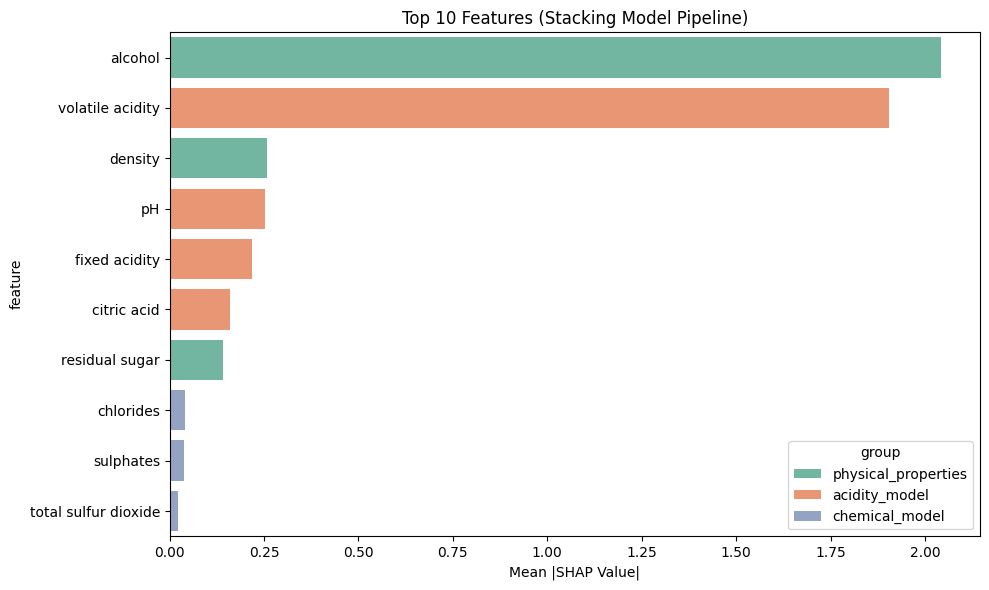


Visualizing prediction path...


<Figure size 640x480 with 0 Axes>

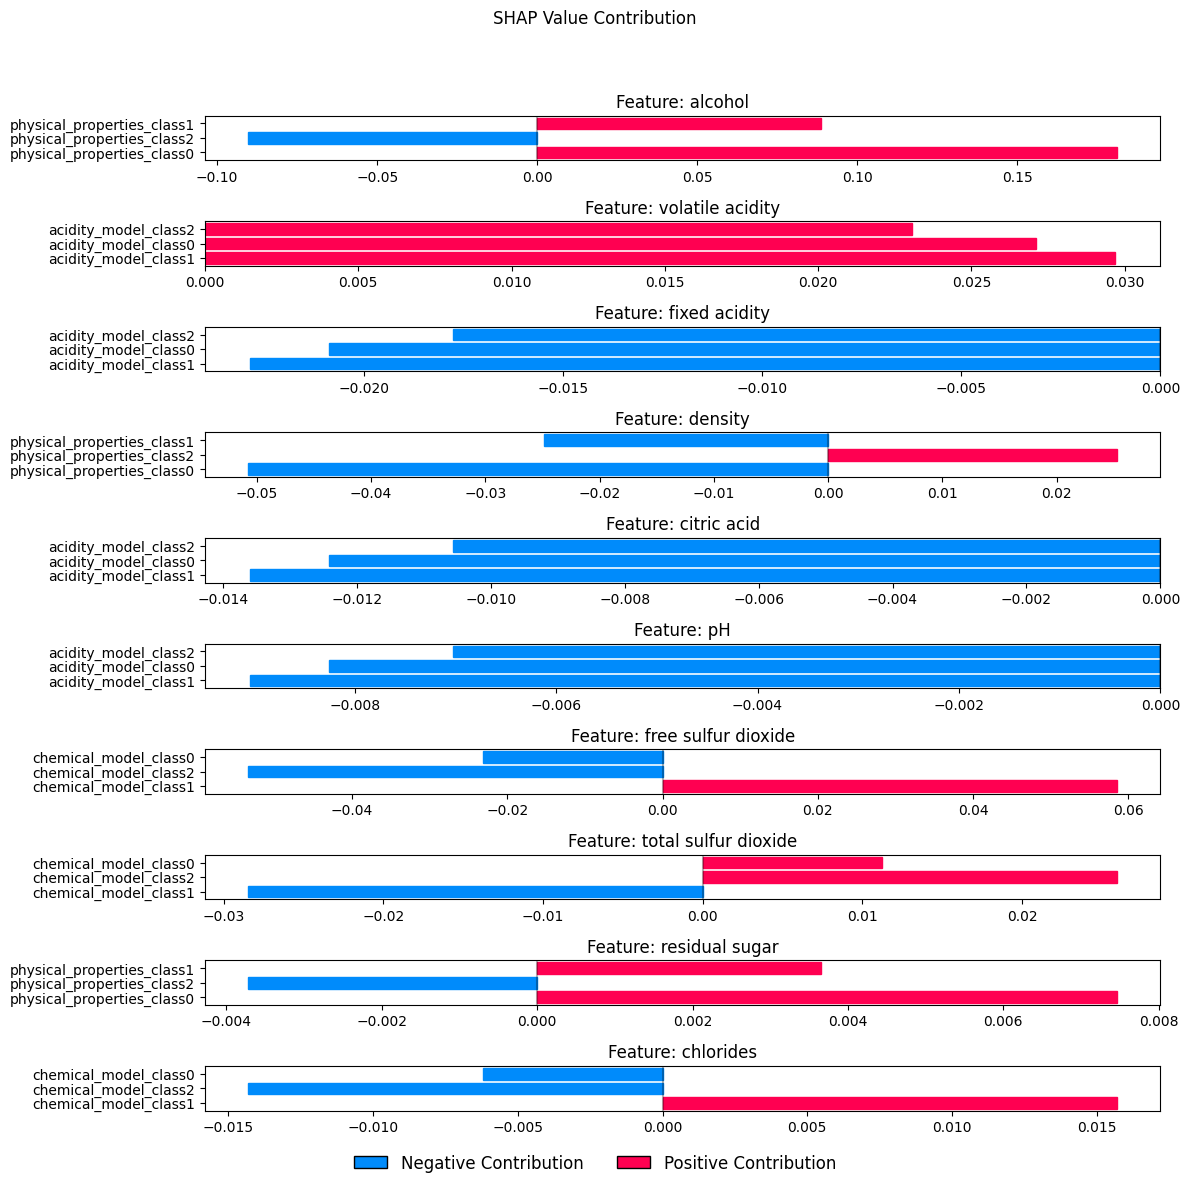


Creating waterfall plot...

Printing detailed SHAP values...

===== DETAILED SHAP VALUES =====

  fixed acidity: -0.061502
  volatile acidity: 0.079854
  citric acid: -0.036569
  pH: -0.024314
  chlorides: -0.004809
  free sulfur dioxide: -0.017936
  total sulfur dioxide: 0.008719
  sulphates: -0.002468
  residual sugar: 0.007396
  density: -0.050285
  alcohol: 0.179514

BASE MODELS SHAP VALUES:
  Model: acidity_model
    fixed acidity: -0.079397
    volatile acidity: 0.103088
    citric acid: -0.047208
    pH: -0.031388
  Model: chemical_model
    chlorides: 0.074946
    free sulfur dioxide: 0.279515
    total sulfur dioxide: -0.135886
    sulphates: 0.038459
  Model: physical_properties
    residual sugar: 0.014496
    density: -0.098555
    alcohol: 0.351834

META-FEATURES VALUES:
  acidity_model_class0: 0.227219
  acidity_model_class1: 0.474671
  acidity_model_class2: 0.298110
  chemical_model_class0: 0.459772
  chemical_model_class1: 0.197444
  chemical_model_class2: 0.342784
  p

<Figure size 640x480 with 0 Axes>

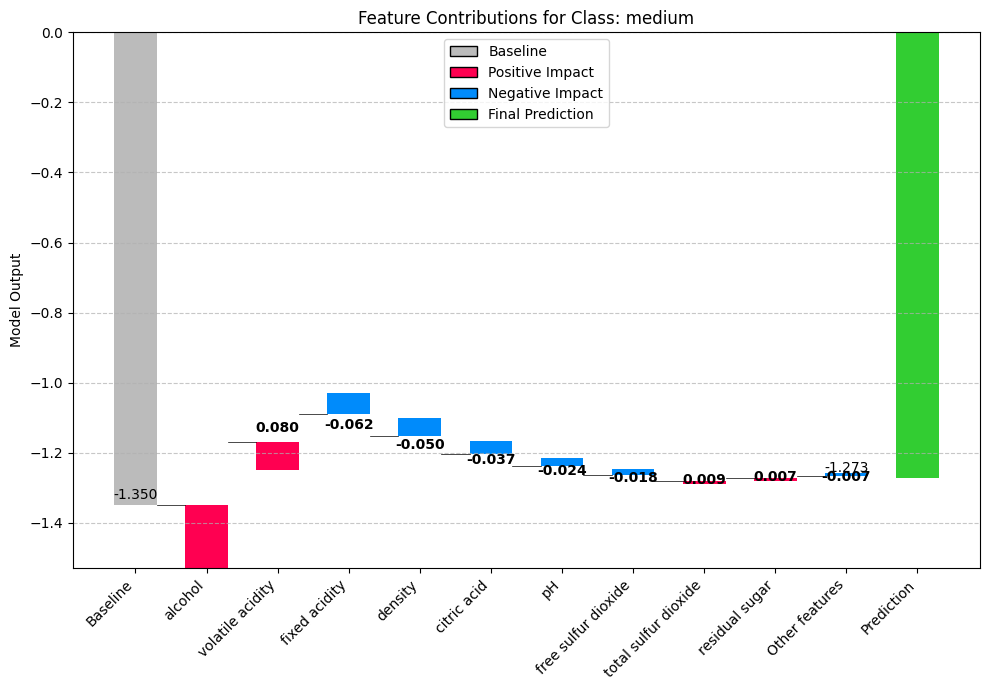

In [14]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import os

def wine_quality_stacking_example(save_plots=True, output_dir='outputs'):
    """
    End-to-end example of using StackModelShapExplainer with a wine quality dataset.
    
    Args:
        save_plots (bool): Whether to save plots to disk instead of displaying
        output_dir (str): Directory to save plots and results
    
    Returns:
        tuple: (stack_model, explainer, X_test, y_test, label_encoder, explanation)
    """
    print("=" * 80)
    print("Wine Quality Stacking Model Example with SHAP Explanations")
    print("=" * 80)
    
    # Create output directory if needed
    if save_plots and not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Generate synthetic wine quality data
    np.random.seed(42)
    n_samples = 1599  # Similar to the real wine quality dataset size
    
    # Feature names for wine quality dataset
    features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
               'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
               'pH', 'sulphates', 'alcohol']
    
    # Generate synthetic data with realistic distributions
    wine_data = {
        'fixed acidity': np.random.normal(7.2, 1.3, n_samples),
        'volatile acidity': np.random.normal(0.34, 0.17, n_samples),
        'citric acid': np.random.normal(0.32, 0.14, n_samples),
        'residual sugar': np.clip(np.random.exponential(2.0, n_samples), 0.9, 15.5),
        'chlorides': np.clip(np.random.exponential(0.05, n_samples), 0.01, 0.6),
        'free sulfur dioxide': np.clip(np.random.normal(30, 17, n_samples), 1, 120),
        'total sulfur dioxide': np.clip(np.random.normal(115, 56, n_samples), 6, 300),
        'density': np.random.normal(0.995, 0.002, n_samples),
        'pH': np.random.normal(3.2, 0.16, n_samples),
        'sulphates': np.random.normal(0.53, 0.15, n_samples),
        'alcohol': np.clip(np.random.normal(10.4, 1.1, n_samples), 8.0, 14.0),
    }
    
    # Generate quality based on feature values to make it more realistic
    # Wine quality is higher with higher alcohol, lower volatile acidity, etc.
    quality = 6 + (wine_data['alcohol'] - 10.4) / 1.1 - (wine_data['volatile acidity'] - 0.34) / 0.17
    quality = np.round(np.clip(quality, 3, 8)).astype(int)
    wine_data['quality'] = quality
    
    # Create DataFrame
    data = pd.DataFrame(wine_data)
    
    # Convert target to multi-class (low, medium, high quality)
    print("\nConverting wine quality to categorical labels...")
    def quality_label(q):
        if q <= 5:
            return 'low'
        elif q == 6:
            return 'medium'
        else:
            return 'high'
    
    data['quality_label'] = data['quality'].apply(quality_label)
    data.drop(columns=['quality'], inplace=True)
    
    # Display class distribution
    class_counts = data['quality_label'].value_counts()
    print("Class distribution:")
    print(class_counts)
    
    # Encode target labels
    label_encoder = LabelEncoder()
    data['quality_label'] = label_encoder.fit_transform(data['quality_label'])
    print(f"Encoded classes: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")
    
    # Features and target
    X = data.drop(columns=['quality_label'])
    y = data['quality_label']
    
    # Split data
    print("\nSplitting data into train and test sets...")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print(f"Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")
    
    # Define model configuration
    print("\nConfiguring stacked model architecture...")
    model_configs = {
        'acidity_model': {
            'feature_names': ['fixed acidity', 'volatile acidity', 'citric acid', 'pH'],
            'estimators': lgb.LGBMClassifier,
            'hyperparameters': {'n_estimators': 100, 'max_depth': 3, 'verbosity': -1}
        },
        'chemical_model': {
            'feature_names': ['chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'sulphates'],
            'estimators': lgb.LGBMClassifier,
            'hyperparameters': {'n_estimators': 100, 'max_depth': 4, 'verbosity': -1}
        },
        'physical_properties': {
            'feature_names': ['residual sugar', 'density', 'alcohol'],
            'estimators': lgb.LGBMClassifier,
            'hyperparameters': {'n_estimators': 100, 'max_depth': 3, 'verbosity': -1}
        }
    }
    
    # Create and train the stacking model
    print("\nTraining stacked model...")
    final_estimator = lgb.LGBMClassifier(n_estimators=50, verbosity=-1)
    stack_model = StackModel(model_configs, final_estimator, cv=5)
    stack_model.fit(X_train, y_train)
    
    # Evaluate model
    print("\nEvaluating model performance...")
    y_pred = stack_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Stacking Model Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    
    # Create SHAP explainer
    print("\nCreating SHAP explainer...")
    explainer = StackModelShapExplainer(stack_model, background_data=X_train, n_background=100)
    
    # Get explanation for a single instance
    instance_idx = 25
    instance = X_test.iloc[[instance_idx]]
    true_class = y_test.iloc[instance_idx]
    class_name = label_encoder.inverse_transform([true_class])[0]
    print(f"\nExplaining prediction for instance with true class: {class_name}")
    
    # Display feature values for selected instance
    print("\nFeature values for the explained instance:")
    for feature in X.columns:
        print(f"{feature}: {instance[feature].values[0]:.4f}")
    
    # Get explanation for the instance
    print("\nGenerating SHAP explanation...")
    explanation = explainer.explain_instance(instance, target_class=true_class)
    
    # Print combined SHAP values
    print("\nTop 5 combined SHAP values (impact on final prediction):")
    for feature, value in sorted(explanation['combined_shap'].items(), 
                               key=lambda x: abs(x[1]), reverse=True)[:5]:
        print(f"{feature}: {value:.6f}")
    
    # Plot feature importance for the dataset
    print("\nPlotting overall feature importance...")
    fig_importance = explainer.plot_feature_importance(
        X_test, 
        target_class=1
    )
    # plt.title(f"Feature Importance for Class: {class_name}")
    
    if save_plots:
        plt.savefig(os.path.join(output_dir, 'feature_importance.png'), dpi=300, bbox_inches='tight')
    else:
        plt.show()
    
    # Visualize prediction path
    print("\nVisualizing prediction path...")
    try:
        fig_path = explainer.visualize_prediction_path(
            instance, 
            target_class=true_class
        )
        if save_plots:
            plt.savefig(os.path.join(output_dir, 'prediction_path.png'), dpi=300, bbox_inches='tight')
        else:
            plt.show()
    except Exception as e:
        print(f"Error visualizing prediction path: {e}")
    
    # Create waterfall plot
    print("\nCreating waterfall plot...")
    fig_waterfall, ax_waterfall = explainer.plot_waterfall(
        instance, 
        target_class=true_class,
        max_features=10
    )
    plt.title(f"Feature Contributions for Class: {class_name}")
    
    if save_plots:
        plt.savefig(os.path.join(output_dir, 'waterfall_plot.png'), dpi=300, bbox_inches='tight')
    else:
        plt.show()
    
    # Print detailed SHAP values
    print("\nPrinting detailed SHAP values...")
    print_detailed_shap_values(explanation, stack_model, target_class=true_class)
    
    # Verify chain rule calculation for top features
    print("\nVerifying chain rule calculations...")
    important_features = [x[0] for x in sorted(
        explanation['combined_shap'].items(), key=lambda x: abs(x[1]), reverse=True
    )[:3]]
    
    for feature in important_features:
        verify_chain_rule_calculation(explanation, stack_model, feature, target_class=true_class)
    
    # Feature influence analysis
    print("\nAnalyzing feature influence paths...")
    for feature in important_features:
        influence = explainer.get_feature_influence(explanation, feature)
        print(f"\nFeature: {feature}")
        print(f"Total influence: {influence['combined_influence']:.6f}")
        print("Influence paths:")
        for meta_feature, value in sorted(influence['influence_paths'].items(), 
                                         key=lambda x: abs(x[1]), reverse=True):
            print(f"  Via {meta_feature}: {value:.6f}")
    
    # Model influence analysis
    print("\nAnalyzing model contributions...")
    for model_name in model_configs.keys():
        model_influence = explainer.get_model_influence(explanation, model_name)
        print(f"\nModel: {model_name}")
        print(f"Total influence: {model_influence['total_influence']}")
        print("Influence through meta-features:")
        for meta_feature, value in model_influence['meta_features'].items():
            print(f"  Via {meta_feature}: {value}")
    
    print("\nExample completed successfully!")
    return stack_model, explainer, X_test, y_test, label_encoder, explanation


if __name__ == "__main__":
    stack_model, explainer, X_test, y_test, label_encoder, explanation = wine_quality_stacking_example()

## A new observation

Predicted wine quality: 0
Prediction probabilities: [0.65455803 0.00402556 0.34141641]


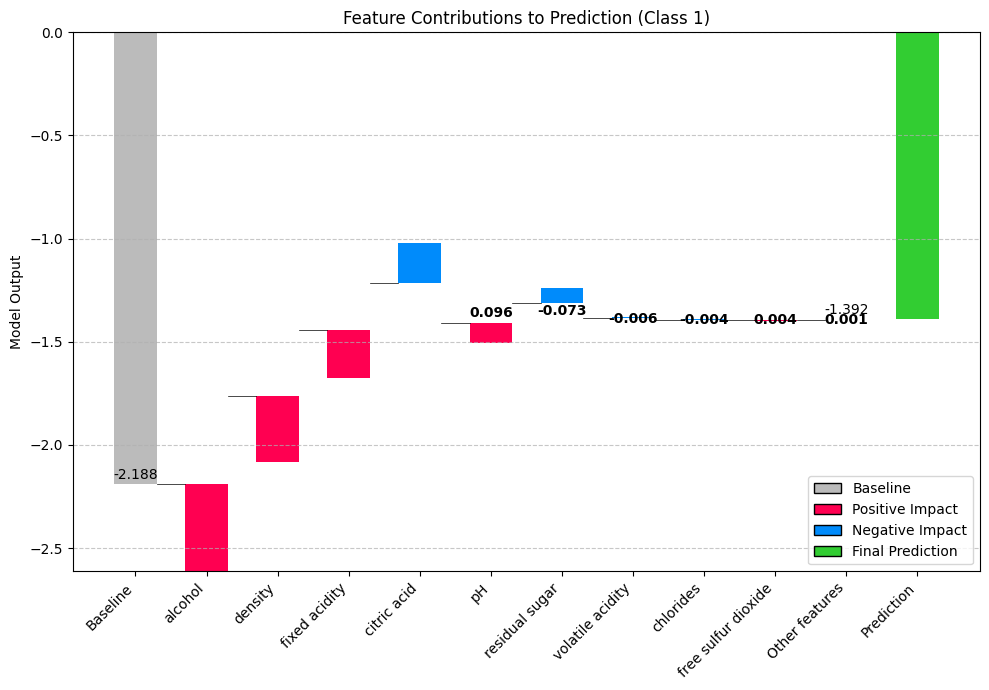

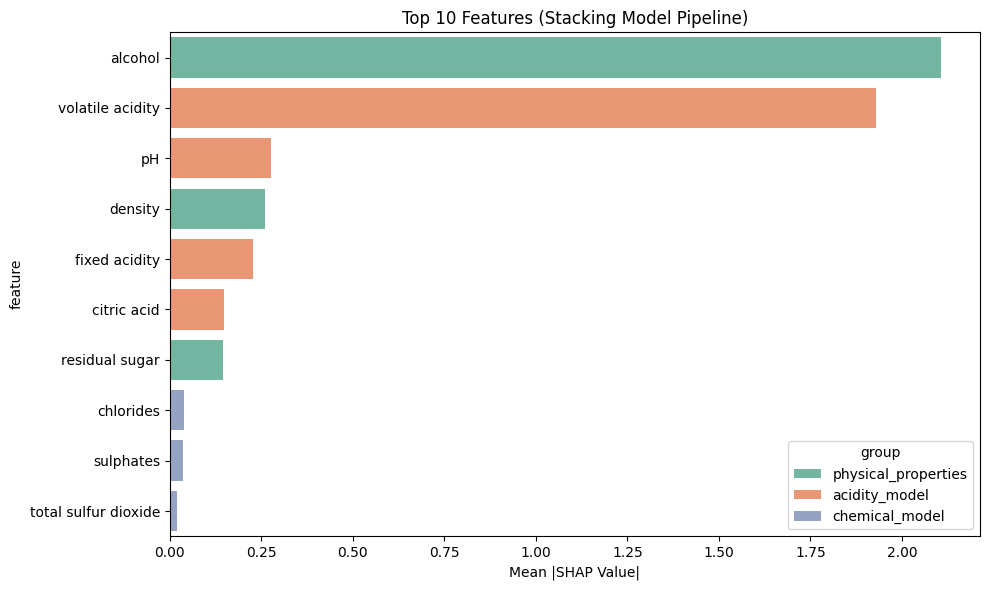

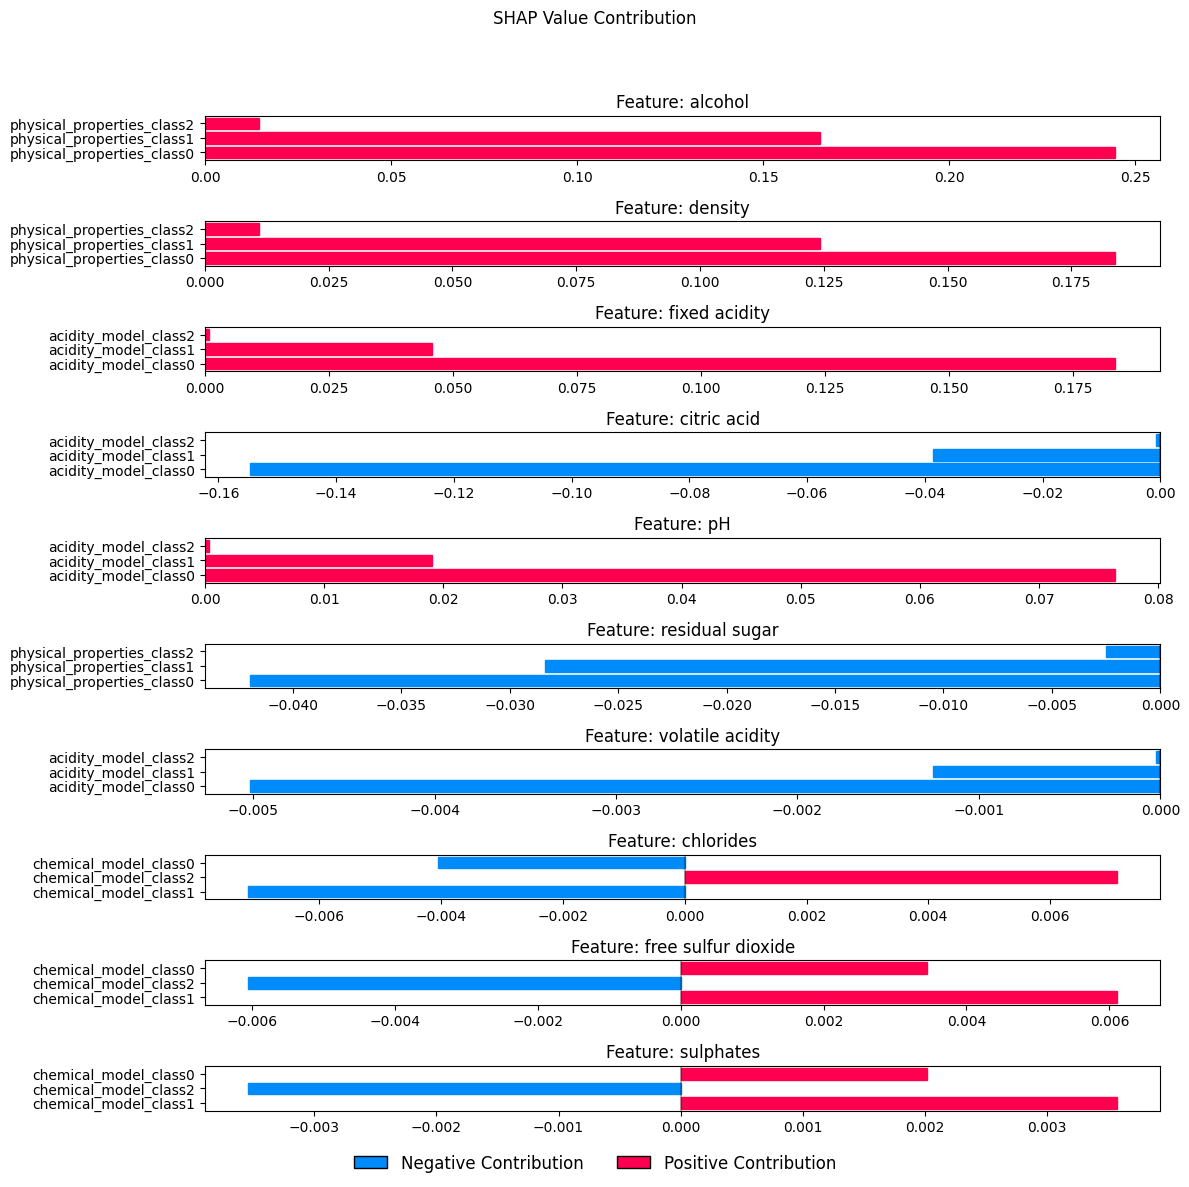


Top 5 most influential features for this prediction:
alcohol: 0.4244
density: 0.3190
fixed acidity: 0.2301
citric acid: -0.1939
pH: 0.0958

Influence paths for 'alcohol':
  → physical_properties_class0: 0.2445
  → physical_properties_class1: 0.1653
  → physical_properties_class2: 0.0146


In [18]:
# Assuming you already have a trained StackModel called 'stack_model'
# and a DataFrame 'X_train' that was used to train the model

# Create a new observation for a wine sample
new_observation = pd.DataFrame([{
    'fixed acidity': 7.0,
    'volatile acidity': 0.35,
    'citric acid': 0.30,
    'residual sugar': 2.0,
    'chlorides': 0.05,
    'free sulfur dioxide': 25.0,
    'total sulfur dioxide': 120.0,
    'density': 0.996,
    'pH': 3.2,
    'sulphates': 0.5,
    'alcohol': 10.5
}])

# Initialize the SHAP explainer with your trained model and training data
explainer = StackModelShapExplainer(
    stack_model=stack_model,
    background_data=X_test,
    n_background=100  # Use 100 background samples for efficiency
)

# Get the prediction for the new observation
prediction = stack_model.predict(new_observation)[0]
probabilities = stack_model.predict_proba(new_observation)[0]

print(f"Predicted wine quality: {prediction}")
print(f"Prediction probabilities: {probabilities}")

# Explain the prediction using the waterfall plot
# If stack_model is a binary classifier, target_class=1 would represent the positive class
fig, ax = explainer.plot_waterfall(new_observation, target_class=1)
plt.show()

# You can also visualize feature importance across the entire model
feature_importance = explainer.plot_feature_importance(X_test, target_class=1)

# For a deeper understanding of how features flow through the model
explanation = explainer.visualize_prediction_path(new_observation, target_class=1)

# If you want to inspect the raw SHAP values
raw_explanation = explainer.explain_instance(new_observation, target_class=1)
print("\nTop 5 most influential features for this prediction:")
for feature, shap_value in sorted(
    raw_explanation['combined_shap'].items(), 
    key=lambda x: abs(x[1]), 
    reverse=True
)[:5]:
    print(f"{feature}: {shap_value:.4f}")

# You can also examine how each feature influences the prediction through different paths
print("\nInfluence paths for 'alcohol':")
if 'alcohol' in raw_explanation['feature_influence_chain']:
    for meta_feature, influence in raw_explanation['feature_influence_chain']['alcohol'].items():
        print(f"  → {meta_feature}: {influence:.4f}")

In [64]:
import pandas as pd

def store_influence_to_predicted_class(explainer, stack_model, new_observation, predicted_class):
    """
    Store the influence of features and models on the predicted class.
    
    Args:
        explainer (StackModelShapExplainer): The SHAP explainer.
        stack_model (StackModel): The trained stacking model.
        new_observation (pd.DataFrame): The feature matrix for a single instance to explain.
        predicted_class (int): The predicted class index for the instance.
    
    Returns:
        tuple: 
            pd.DataFrame: DataFrame containing feature influences on the predicted class.
            pd.DataFrame: DataFrame containing model influences on the predicted class.
    """
    
    # Get the SHAP explanation for the given observation and predicted class
    explanation = explainer.explain_instance(new_observation, target_class=predicted_class)

    # Initialize lists to store feature and model influence data
    feature_influence_data = []
    model_influence_data = []
    
    # ---- Store feature influence ----
    for feature in new_observation.columns:  # Loop through all features
        feature_influence = explainer.get_feature_influence(explanation, feature)
        total_influence = feature_influence['combined_influence']
        influence_paths = feature_influence['influence_paths']
        
        # Store feature influence data
        for meta_feature, influence in sorted(influence_paths.items(), key=lambda x: abs(x[1]), reverse=True):
            feature_influence_data.append({
                'Feature': feature,
                'Meta Feature': meta_feature,
                'Influence': influence,
                'Total Influence': total_influence,
                'Predicted Class': predicted_class
            })
    
    # ---- Store model influence ----
    for model_name in stack_model.models.keys():  # Loop through all models
        model_influence = explainer.get_model_influence(explanation, model_name)
        total_influence = model_influence['total_influence']
        meta_feature_influences = model_influence['meta_features']
        
        # Store model influence data
        for meta_feature, influence in meta_feature_influences.items():
            model_influence_data.append({
                'Model': model_name,
                'Meta Feature': meta_feature,
                'Influence': influence,
                'Total Influence': total_influence,
                'Predicted Class': predicted_class
            })
    
    # Convert the lists into separate DataFrames
    feature_influence_df = pd.DataFrame(feature_influence_data)
    model_influence_df = pd.DataFrame(model_influence_data)
    
    return feature_influence_df, model_influence_df


# Example Usage
# Assuming you already have a trained 'stack_model', 'explainer', and a new observation
# Let's assume the predicted class is 1 (medium quality wine in the example dataset)
new_observation = pd.DataFrame([{
    'fixed acidity': 7.0,
    'volatile acidity': 0.35,
    'citric acid': 0.30,
    'residual sugar': 2.0,
    'chlorides': 0.05,
    'free sulfur dioxide': 25.0,
    'total sulfur dioxide': 120.0,
    'density': 0.996,
    'pH': 3.2,
    'sulphates': 0.5,
    'alcohol': 10.5
}])

predicted_class = 1  # For example, class 1 (e.g., medium quality in the wine dataset)

# Call the function to store influences for the predicted class
feature_influence_df, model_influence_df = store_influence_to_predicted_class(explainer, stack_model, new_observation, predicted_class)




In [66]:
file_name = 'influence_df.xlsx'
with pd.ExcelWriter(file_name, engine='xlsxwriter') as writer:
    # Save each DataFrame to a different sheet
    feature_influence_df.to_excel(writer, sheet_name='Feature Influence', index=False)
    model_influence_df.to_excel(writer, sheet_name='Model Influence', index=False)

In [67]:
predicted_class = 0 
feature_influence_df, model_influence_df = store_influence_to_predicted_class(explainer, stack_model, new_observation, predicted_class)
file_name = 'influence_df0.xlsx'
with pd.ExcelWriter(file_name, engine='xlsxwriter') as writer:
    # Save each DataFrame to a different sheet
    feature_influence_df.to_excel(writer, sheet_name='Feature Influence', index=False)
    model_influence_df.to_excel(writer, sheet_name='Model Influence', index=False)

In [68]:
explanation = explainer.explain_instance(new_observation, target_class=1)
explanation

{'combined_shap': {'fixed acidity': 0.23006162160601437,
  'volatile acidity': -0.006290676600541171,
  'citric acid': -0.1938829505432772,
  'pH': 0.0957712563895823,
  'chlorides': -0.004115580133319979,
  'free sulfur dioxide': 0.0035060000889678335,
  'total sulfur dioxide': -0.0008107644553777969,
  'sulphates': 0.002053618847751592,
  'residual sugar': -0.07281704415414081,
  'density': 0.31899564561470933,
  'alcohol': 0.4244219215434195},
 'feature_influence_chain': {'fixed acidity': {'acidity_model_class0': 0.1834103026442602,
   'acidity_model_class1': 0.045779502543218616,
   'acidity_model_class2': 0.0008718164185355561},
  'volatile acidity': {'acidity_model_class0': -0.005015068967558123,
   'acidity_model_class1': -0.0012517691713319287,
   'acidity_model_class2': -2.383846165111903e-05},
  'citric acid': {'acidity_model_class0': -0.15456785181494598,
   'acidity_model_class1': -0.03858038105409343,
   'acidity_model_class2': -0.000734717674237794},
  'pH': {'acidity_mod